In [47]:
using InteractiveUtils, Pkg, Revise
Pkg.activate("../tests")
versioninfo(); Pkg.status()

  Activating project at `~/src/AdvancedHMC.jl/research/tests`


Julia Version 1.9.1
Commit 147bdf428cd (2023-06-07 08:27 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × AMD EPYC 7R32
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver2)
  Threads: 11 on 32 virtual cores
Environment:
  JULIA_NUM_THREADS = 10
Status `~/src/AdvancedHMC.jl/research/tests/Project.toml`
⌃ [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.6 `~/src/AdvancedHMC.jl`
  [6e4b80f9] BenchmarkTools v1.3.2
  [863f3e99] Comonicon v1.0.5
  [163ba53b] DiffResults v1.1.0
⌃ [31c24e10] Distributions v0.25.95
⌅ [366bfd00] DynamicPPL v0.22.4
⌃ [6a86dc24] FiniteDiff v2.20.0
  [f6369f11] ForwardDiff v0.10.35
⌃ [7073ff75] IJulia v1.24.0
  [6d524b87] MCMCDebugging v0.2.1
⌃ [91a5bcdd] Plots v1.38.13
⌃ [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.14.6
  [a8a75453] StatProfilerHTML v1.5.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl.git#main`
In

In [48]:
using PyPlot: matplotlib
const plt = matplotlib.pyplot
plt.style.use("bmh")

using Statistics, Distributions

function subplots(args...; kwargs...)
    res = plt.subplots(args...; kwargs...)
    plt.close(res[1])
    return res
end

subplots (generic function with 1 method)

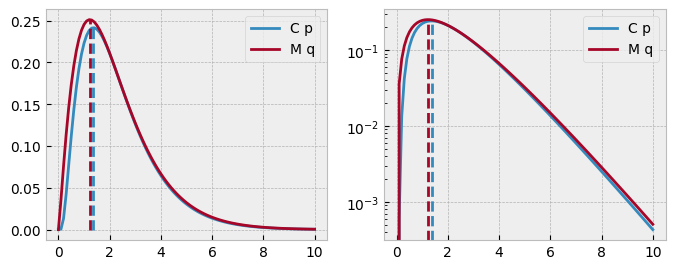

In [49]:
C_p(x, a, b, p) = x^(p - 1) * exp(-(a * x + b / x) / 2)
M_q(x, α, β)    = x^(α - 1) * exp(-(β * x))
function r_p_q(a, b, p, α, β)
    x_m = b / 2 / (α - p)
    return (1 / x_m)^(α - p) * exp(-b / 2 * (1 / x_m))
end

mode_p(a, b, p) = (p - 1 + sqrt((p - 1)^2 + a * b)) / a
mode_q(α, β)    = (α - 1) / β

# Proposal 1: simple substitutions
# gig2gamma(a, b, p) = (p, a / 2)
# Proposal 2: matching mode
# gig2gamma(a, b, p) = ((p + 1) / 2 + sqrt((p - 1)^2 + a * b) / 2, a / 2)
# Proposal 3: β-substitution with "optimal" α by Lars Mescheder (https://scholar.google.com/citations?user=h2k1gL4AAAAJ)
# Ref: https://github.com/LMescheder/GenInvGaussian.jl/blob/master/src/GenInvGaussian.jl
gig2gamma(a, b, p) = (p / 2 + sqrt(p^2 + a * b) / 2, a / 2)
# Proposal 4: α-substitution with optimal β (Dagpunar, 2007)

fig, axes = subplots(1, 2, figsize=(2 * 4, 3))

let a = 2.0, b = 1.0, p = 2.0
    x_vec = 0:0.1:10
    density_vec_p = C_p.(x_vec, a, b, p)
    α, β = gig2gamma(a, b, p)
    density_vec_q = M_q.(x_vec, α, β) * r_p_q(a, b, p, α, β)
    for ax in axes
        ax.plot(x_vec, density_vec_p, color="C0", label="C p")
        ax.vlines(mode_p(a, b, p), 0, maximum(density_vec_p), linestyle="--", color="C0")

        ax.plot(x_vec, density_vec_q, color="C1", label="M q")
        ax.vlines(mode_q(α, β), 0, maximum(density_vec_q), linestyle="--", color="C1")
    end
end

foreach(ax -> ax.legend(), axes)
axes[2].set_yscale("log")

fig

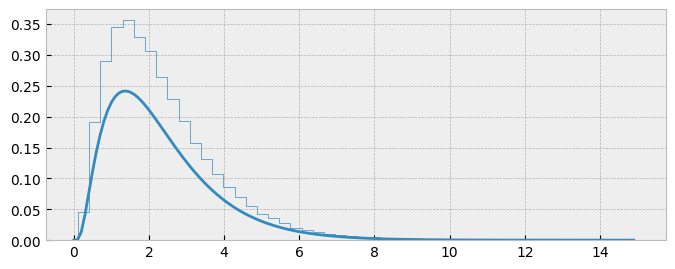

In [50]:
using Random: AbstractRNG, GLOBAL_RNG

function rand_gig(rng::AbstractRNG, a, b, p)
    if a == 0 || b == 0 || p == -1/2
        # Special cases of GIG
        # Ref: https://en.wikipedia.org/wiki/Generalized_inverse_Gaussian_distribution
        if a == 0
            error("NotImplemented")
            dist = InverseGamma(α, β)
        end
        if b == 0
            α, β = p, a / 2
            dist = Gamma(α, β)
        end
        if p == -1/2
            μ, λ = sqrt(b / a), b
            dist = InverseGaussian(μ, λ)
        end
        return rand(rng, dist)
    else
        α, β = gig2gamma(a, b, p)
        proposal = Gamma(α, β)
        r = r_p_q(a, b, p, α, β)
        while true
            candidate = rand(rng, proposal)
            if rand(rng) <= (C_p(candidate, a, b, p) / (M_q(candidate, α, β) * r))
                return candidate
            end
        end
    end
end

rand_gig(a, b, p) = rand_gig(GLOBAL_RNG, a, b, p)

fig, ax = subplots(figsize=(8, 3))

let a = 2.0, b = 1.0, p = 2.0
    sample_vec = [rand_gig(a, b, p) for _ in 1:100_000]
    x_vec = 0:0.1:maximum(sample_vec)
    ax.plot(x_vec, C_p.(x_vec, a, b, p), color="C0")
    ax.hist(sample_vec, density=true, bins=50, histtype="step", color="C0")
end

fig

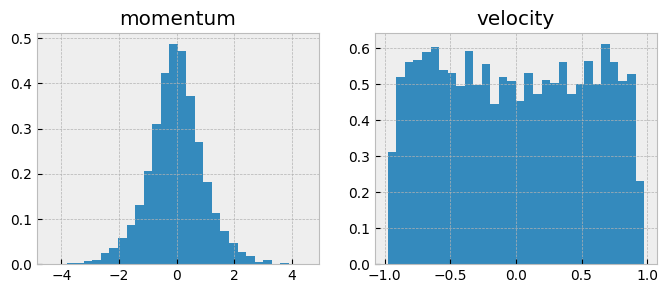

In [51]:
function rand_nvmm(rng::AbstractRNG, ᾱ, β̄, σ, a, b, p)
    dist_X = Normal(0, 1)
    X = rand(rng, dist_X)

    V = rand_gig(rng, a, b, p)

    Y = ᾱ + β̄ * V + σ * sqrt(V) * X

    return Y
end

rand_nvmm(ᾱ, β̄, σ, a, b, p) = rand_nvmm(GLOBAL_RNG, ᾱ, β̄, σ, a, b, p)

m = 1.0
c = 1.0
momentum_vec = let ᾱ = 0.0,
            β̄ = 0.0,
            σ = 1.0,
            a = c^2,
            b = m^2 * c^2,
            p = 1.0
    [rand_nvmm(ᾱ, β̄, σ, a, b, p) for _ in 1:5_000]
end
velocity_vec = momentum_vec ./ (m * sqrt.(momentum_vec.^2 / m^2 / c^2 .+ 1))

fig, (ax1, ax2) = subplots(1, 2, figsize=(2 * 4, 3))

ax1.hist(momentum_vec; bins=30, density=true)
ax1.set_title("momentum")
ax2.hist(velocity_vec; bins=30, density=true)
ax2.set_title("velocity")

fig

In [52]:
using LinearAlgebra
using AdaptiveRejectionSampling: RejectionSampler, run_sampler!

function log_C_p(x, m, c)
    return -m * c^2 * sqrt(dot(x, x) / (m^2 * c^2) + 1)
end
C_p(x, args...) = exp(log_C_p(x, args...))

function log_M_q(x, c)
    return -c * sqrt(dot(x, x))
end
log_M_q(x, _, c) = log_M_q(x, c)
M_q(x, args...) = exp(log_M_q(x, args...))

fig, axes = subplots(1, 2, figsize=(2 * 7, 6))

let m = 1.0, c = 1.0
    x_vec = -10:0.1:+10
    density_vec_p = C_p.(x_vec, m, c)
    density_vec_q = M_q.(x_vec, m, c)
    sampler_p = RejectionSampler(x -> C_p(x, m, c), (-Inf, Inf); max_segments=5)
    sample_vec_p = run_sampler!(sampler_p, 1_000)
    sampler_q = RejectionSampler(x -> M_q(x, m, c), (-Inf, Inf); max_segments=5)
    sample_vec_q = run_sampler!(sampler_q, 1_000)
    for ax in axes
        ax.plot(x_vec, density_vec_p, lw=1.0, color="C0", label="C p")
        ax.hist(sample_vec_p, density=true, histtype="step", bins=30, color="C0")
        ax.plot(x_vec, density_vec_q, lw=1.0, color="C1", label="M q")
        ax.hist(sample_vec_q, density=true, histtype="step", bins=30, color="C1")
    end
end

foreach(ax -> ax.legend(), axes)
axes[2].set_yscale("log")

fig

LoadError: AssertionError: couldn't find initial points, please provide them or change `search_range`

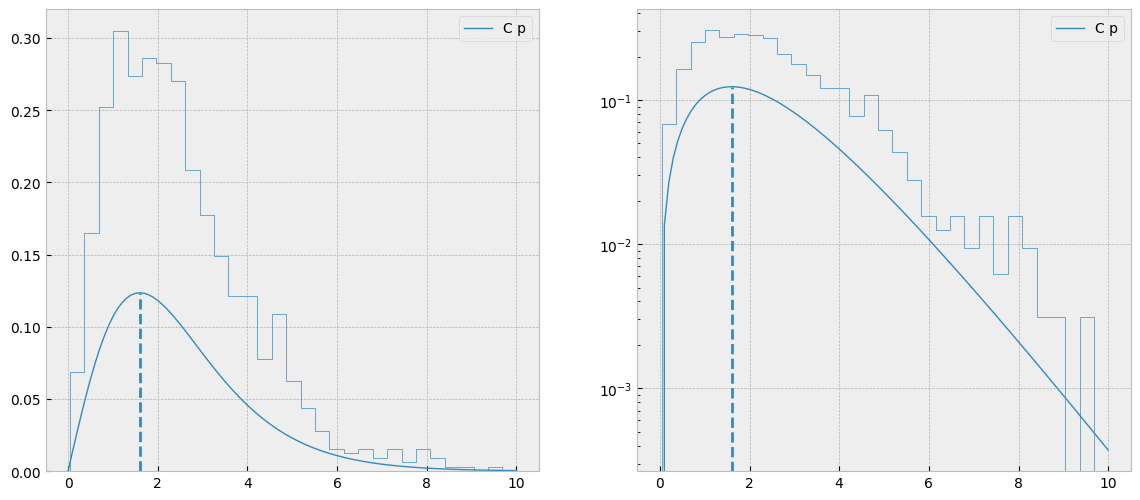

In [54]:
mm(m, c) = sqrt((1 / c^2 + sqrt(1 / c^2 + 4 * m^2)) / 2)

function log_C_p(x, m, c)
    return -m * c^2 * sqrt(dot(x, x) / (m^2 * c^2) + 1)
end
C_p(x, args...) = exp(log_C_p(x, args...)) * x

function log_M_q(x, c)
    return -c * sqrt(dot(x, x))
end
log_M_q(x, _, c) = log_M_q(x, c)
M_q(x, args...) = exp(log_M_q(x, args...)) * x

fig, axes = subplots(1, 2, figsize=(2 * 7, 6))

let m = 2.0, c = 1.0
    x_vec = 0:0.1:+10
    density_vec_p = C_p.(x_vec, m, c)
    density_vec_q = M_q.(x_vec, m, c)
    sampler_p = RejectionSampler(x -> C_p(x, m, c), (0.0, Inf), (mm(m, c) / 2, mm(m, c) * 2); max_segments=5)
    sample_vec_p = run_sampler!(sampler_p, 1_000)
    # sampler_q = RejectionSampler(x -> M_q(x, m, c), (0.0, Inf); max_segments=5)
    # sample_vec_q = run_sampler!(sampler_q, 1_000)
    for ax in axes
        ax.plot(x_vec, density_vec_p, lw=1.0, color="C0", label="C p")
        ax.vlines(mm(m, c), 0, maximum(density_vec_p), linestyle="--", color="C0")
        ax.hist(sample_vec_p, density=true, histtype="step", bins=30, color="C0")
        # ax.plot(x_vec, density_vec_q, lw=1.0, color="C1", label="M q")
        # ax.hist(sample_vec_q, density=true, histtype="step", bins=30, color="C1")
    end
end

foreach(ax -> ax.legend(), axes)
axes[2].set_yscale("log")

fig

[ Info: (2, 5000)


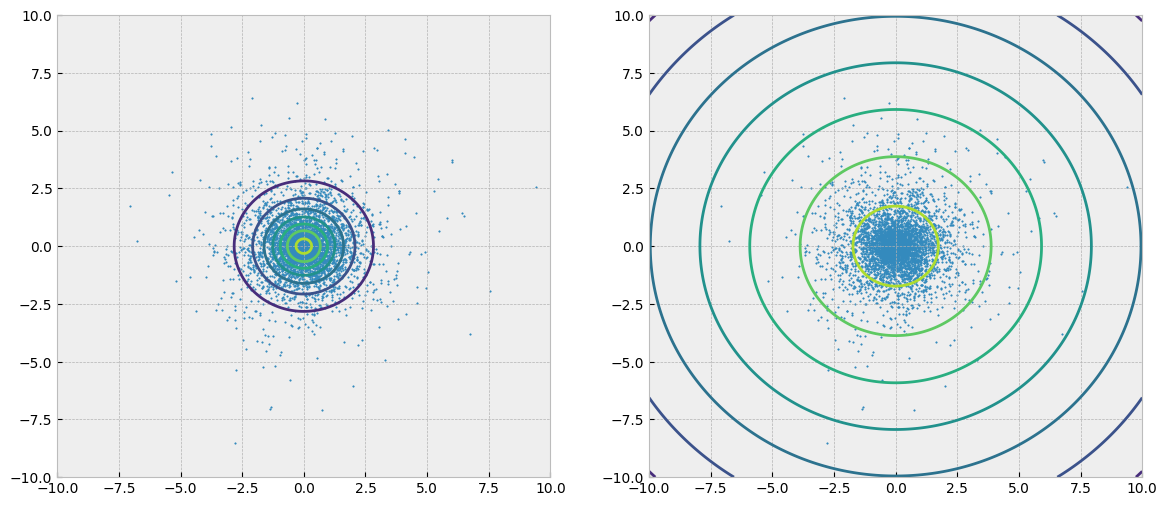

In [75]:
polar2carte(θ, d) = d * [cos(θ), sin(θ)]

fig, axes = subplots(1, 2, figsize=(2 * 7, 6))
# fig, axes = subplots(1, 2, figsize=(2 * 7, 6), subplot_kw=Dict("projection"=>"3d"))

let m = 1.0, c = 1.0
    x1_vec = -10:0.1:+10
    x2_vec = -10:0.1:+10
    l1 = length(x1_vec)
    l2 = length(x2_vec)
    x1_mat = zeros(l1, l2)
    x2_mat = zeros(l1, l2)
    density_mat_p = zeros(l1, l2)
    density_mat_q = zeros(l1, l2)
    for (i, x1) in enumerate(x1_vec), 
        (j, x2) in enumerate(x2_vec)
        x1_mat[i,j] = x1
        x2_mat[i,j] = x2
        density_mat_p[i,j] = C_p([x1, x2], m, c)
        density_mat_q[i,j] = M_q([x1, x2], m, c)
    end
    num_samples = 5_000
    θ_vec_p = 2 * π * rand(num_samples)
    sampler_p = RejectionSampler(x -> C_p(x, m, c), (-Inf, Inf); max_segments=5)
    d_vec_p = run_sampler!(sampler_p, num_samples)
    x_mat = reduce(hcat, polar2carte.(θ_vec_p, d_vec_p))
    @info size(x_mat)
    for (ax, f) in zip(axes, [identity, log])
        ax.contour(x1_mat, x2_mat, f.(density_mat_p))
        # ax.contour(x1_mat, x2_mat, f.(density_mat_q))
        ax.scatter(x_mat[1,:], x_mat[2,:], s=1.0)
        # ax.plot_surface(x1_mat, x2_mat, f.(density_mat_p))
        # ax.plot_surface(x1_mat, x2_mat, f.(density_mat_q), alpha=0.4)
    end
end

fig